### Kaggle bootstrapping

In [4]:
# Kaggle COMPETITION bootstrapping
COMPETITION_NAME = 'nlp-getting-started'

!pip install -qq fastai
!pip install -qq kaggle

from fastai.imports import *
np.set_printoptions(linewidth=130)

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

# get competition data
if iskaggle:
    path = Path('../input/'+COMPETITION_NAME)
else:
    DOWNLOADS = Path('downloads')
    import zipfile,kaggle
    path = DOWNLOADS / COMPETITION_NAME
    if not path.is_dir():
        kaggle.api.competition_download_cli(COMPETITION_NAME, path=DOWNLOADS)
        zipfile.ZipFile(f'{path}.zip').extractall(path)
print('done')

100%|██████████| 593k/593k [00:00<00:00, 6.85MB/s]

done


In [19]:
!ls {path}

sample_submission.csv  test.csv  train.csv


### Explore the data

In [21]:
df = pd.read_csv(path/'train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [22]:
df.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [24]:
df.describe(include='all')

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


In [25]:
df.keyword.value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [26]:
df.location.value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

In [32]:
df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [40]:
# sample non-disaster tweet
df[df.target == 0].text.values[0]

"What's up man?"

In [41]:
# sample disaster tweet
df[df.target == 1].text.values[1]

'Forest fire near La Ronge Sask. Canada'

### Data cleanup

In [ ]:
# TODO

### Preprocess the data

In [33]:
df['text_len'] = df.text.str.len()
df

,id,keyword,location,text,target,text_len
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,88
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1,83
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1,125
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1,65
7611,10872,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1,137


In [45]:
df.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'text_len'], dtype='object')

### Let's try using fastai for NLP!

In [42]:
from fastai.text.all import *

In [46]:
dls = TextDataLoaders.from_df(df, path, text_col='text', label_col='target')

In [47]:
dls.show_batch()

,text,category
0,xxbos _ \n▁ xxrep 5 ? xxup retweet \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup follow xxup all xxup who xxup rt \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup xxunk \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup gain xxup with \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup follow ? xxunk # xxup xxunk \n▁ # xxup ty,0
1,xxbos xxup info xxup r. xxup curfew xxup in xxup oper xxup until 2030 xxup z. xxup taxiways xxup foxtrot 5 & & xxup foxtrot 6 xxup navbl . xxup wnd : xxunk / 5 . xxup exp xxup inst xxup apch . xxup rwy 05 . xxup xxunk . xxup tmp : 10 . xxup xxunk : xxunk .,0
2,xxbos xxup info xxup u. xxup xxunk : xxup xxunk xxup xxunk . xxup exp xxup inst xxup apch . xxup rwy 05 . xxup curfew xxup in xxup oper xxup until 2030 xxup z. xxup taxiways xxup foxtrot 5 & & xxup foxtrot 6 xxup navbl . xxup tmp : 10 . xxup wnd : xxunk / 6 .,0
3,xxbos i xxmaj hate xxmaj to xxmaj talking xxmaj xxunk xxmaj with xxmaj my xxmaj xxunk … i xxmaj mean i xxmaj love xxmaj her xxmaj as xxmaj to xxmaj death xxmaj but xxmaj she xxmaj talk xxmaj so xxmaj damn xxmaj much xxmaj xxunk xxrep 3 h xxrep 3 e xxunk xxrep 3 ! xxrep 6 ?,0
4,xxbos xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk,1
5,xxbos xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk,0
6,xxbos xxmaj rare xxunk into # terror and xxmaj how to fight it http : / / t.co / xxunk # xxmaj cameroon # xxup usa # xxmaj xxunk # xxup xxunk # xxup fr # xxmaj nigeria # xxup uk # xxmaj africa # xxup de # xxup ca # xxup xxunk # xxup xxunk,1
7,xxbos xxmaj learn xxmaj how i xxmaj gained xxmaj access xxmaj to xxmaj the xxmaj secrets xxmaj of xxmaj the xxmaj top xxmaj earners & & xxmaj used xxmaj them xxmaj to xxmaj explode xxmaj my xxmaj home xxmaj business xxmaj here : http : / / t.co / xxunk xxmaj please # xxup rt,0
8,xxbos xxmaj learn xxmaj how i xxmaj gained xxmaj access xxmaj to xxmaj the xxmaj secrets xxmaj of xxmaj the xxmaj top xxmaj earners & & xxmaj used xxmaj them xxmaj to xxmaj explode xxmaj my xxmaj home xxmaj business xxmaj here : http : / / t.co / xxunk xxmaj please # xxup rt,0


In [51]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

SuggestedLRs(valley=0.0030199517495930195)

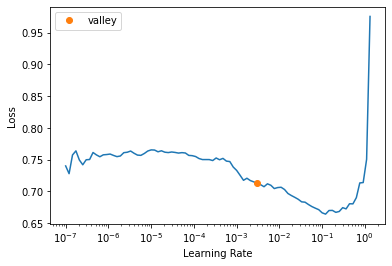

In [52]:
learn.lr_find()

In [53]:
learn.fine_tune(3, 5e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.590051,0.522868,0.751643,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.539972,0.473113,0.810118,00:08
1,0.469829,0.432081,0.821945,00:08
2,0.381462,0.430643,0.824573,00:08


In [54]:
learn.show_results()

,text,category,category_
0,xxbos xxup info xxup s. xxup wnd : xxunk / 6 . xxup xxunk : xxup xxunk xxup xxunk . xxup exp xxup inst xxup apch . xxup rwy 05 . xxup curfew xxup in xxup oper xxup until 2030 xxup z. xxup taxiways xxup foxtrot 5 & & xxup foxtrot 6 xxup navbl . xxup tmp : 10 .,0,0
1,xxbos xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk,1,1
2,xxbos xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk,1,1
3,xxbos xxmaj learn xxmaj how i xxmaj gained xxmaj access xxmaj to xxmaj the xxmaj secrets xxmaj of xxmaj the xxmaj top xxmaj earners & & xxmaj used xxmaj them xxmaj to xxmaj explode xxmaj my xxmaj home xxmaj business xxmaj here : http : / / t.co / xxup xxunk xxmaj please # xxup rt,0,0
4,xxbos xxmaj learn xxmaj how i xxmaj gained xxmaj access xxmaj to xxmaj the xxmaj secrets xxmaj of xxmaj the xxmaj top xxmaj earners & & xxmaj used xxmaj them xxmaj to xxmaj explode xxmaj my xxmaj home xxmaj business xxmaj here : http : / / t.co / xxunk xxmaj please # xxup rt,0,0
5,xxbos xxmaj the xxmaj fake of xxmaj xxunk xxmaj xxunk xxmaj xxunk ( english ): http : / / t.co / xxunk # xxmaj obama # xxmaj clinton # xxmaj bush # xxup gop # xxup abc # xxup xxunk # xxup bbc # xxup cnn # xxup xxunk # xxup xxunk,1,0
6,xxbos xxmaj morgan xxmaj silver xxmaj dollar xxunk p xxup xxunk xxmaj gem xxmaj bu xxup xxunk xxmaj blazing xxup ms xxrep 6 + xxmaj xxunk xxmaj rare xxmaj proof xxmaj like ! - xxmaj full reû _ http : / / t.co / xxunk http : / / t.co / xxunk,0,0
7,xxbos # nowplaying * xxmaj cliff xxmaj richard - i xxmaj could xxmaj easily xxmaj fall ( in xxmaj love xxmaj with xxmaj you ) ( & & xxmaj xxunk ) * # xxmaj internet # xxmaj xxunk # xxmaj radio xxmaj on http : / / t.co / xxunk,0,0
8,xxbos xxmaj xxunk xxmaj hot xxmaj deals # xxunk > > http : / / t.co / xxunk xxunk xxunk xxunk xxunk xxup led xxmaj work xxmaj light xxup flood xxmaj lamp xxmaj xxunk xxmaj truck xxup suv xxup xxunk xxup aû _ http : / / t.co / xxunk,0,0


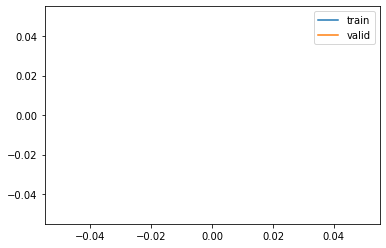

In [61]:
learn.recorder.plot_loss()

### predictions for test data

In [57]:
test_df = pd.read_csv(path/'test.csv')
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [63]:
test_dl = dls.test_dl(test_df)
preds, _, decoded = learn.get_preds(dl=test_dl, with_decoded=True)

In [65]:
decoded.shape

torch.Size([3263])

### Submission

In [56]:
submission = pd.read_csv(path/'sample_submission.csv')
submission.shape

(3263, 2)

In [59]:
submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [66]:
submission.target = decoded
submission.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1


### send submission to Kaggle!

In [68]:
# write submission csv
technique = 'baseline-fastai-learner'
sub_filename = Path('subs')/(COMPETITION_NAME+'-'+technique+'-sub.csv')
submission.to_csv(sub_filename, index=False)

if not iskaggle:
    print('about to submit', sub_filename, 'to kaggle')
    input('continue?')
    ret = kaggle.api.competition_submit(sub_filename, technique, COMPETITION_NAME)
    print(ret)

about to submit subs/nlp-getting-started-baseline-fastai-learner-sub.csv to kaggle


continue? y


100%|██████████| 22.2k/22.2k [00:00<00:00, 42.4kB/s]


Successfully submitted to Natural Language Processing with Disaster Tweets
